# 整数规划 Integer Progrmming

In [1]:
import os
os.chdir('..')  # 改变工作路径

## 女子体操选人

![](./attachments/IntegerProgramming_gymnastics.png)

**这里的数据就不截图了，直接使用..datastructure.probability.pmf.ProbabilityMassFunction 类来表示某运动员在某一项中得分的的分布律，有10个运动员，4个小项，总共有24个分布律。**

先导入数据，这里用了分数而不是浮点作为元数据，虽然使最后一轮跑了3分钟而不是十多秒，但提高了精度

In [2]:
import numpy as np
from rich import print
from dataclasses import dataclass
from datastructure.probability.pmf import ProbabilityMassFunction as PMF
from datastructure.probability.pmf import (create_pmftree, graph_pmftree, plot_pmf, plot_cdf)
from fractions import Fraction
@dataclass
class ProbabilityMass:  # 辅助
    """p_p: ((float,), float)"""
    p_p: tuple

def probability_mass(point: float, probability: float):
    """不能返回序列, 如元组, 因为ndarray需要元素的类型一致, 故返回一个辅助的对象"""
    return ProbabilityMass(((point,), probability))  # (point,) 一个元素的元组需要加个','

with open('./chapters/attachments/IP_gym_grade.txt', 'r', encoding='utf-8') as f:
    # grade = list(map(float, f.read().strip().split('\n')))
    grade = list(map(Fraction, f.read().strip().split('\n')))  # 改为分数提高精度
with open('./chapters/attachments/IP_gym_probability.txt', 'r', encoding='utf-8') as f:
    # probability = list(map(float, f.read().strip().split('\n')))
    probability = list(map(Fraction, f.read().strip().split('\n')))
grade, probability = [np.array(arr).reshape(4, 10, 4) for arr in [grade, probability]]
# reshappe (1, 160) -> (4, 10, 4)
pmfs = np.vectorize(probability_mass)(grade, probability)  # 对最小单位元素进行操作
pmfs: np.ndarray = np.apply_along_axis(lambda x: PMF([ele.p_p for ele in x]), 2, pmfs)
# 选定axis(2)进行操作, lambda输入实参即 (4, 10, 4) 中的第二个4, 一个四维向量
print(pmfs.shape)  # pmfs: np.ndarray[PMF]


(4, 10)

列出规划方程：
$$
min \sum\limits_{i=1}^{4} \sum\limits_{j=1}^{10} c_{ij} x_{ij}
$$ 
$$
s.t. 
    \begin{cases}
    \sum\limits_{i=1}^{4} \sum\limits_{j=1}^{10} x_{ij} = 24 \\
    \sum\limits_{j=1}^{10} x_{ij} = 6 \\
    \sum\limits_{j=1}^{10} s_{j} = 4 \\
    \sum\limits_{i=1}^{4} x_{ij} >= 4 s_{j},\space j = 1, 2, ..., 10. \\
    x_{ij}, s_{ij} = 0 \space or \space 1,\space i = 1, 2, 3, 4, j = 1, 2, ..., 10. \\
    \end{cases}
$$
其中$ c_{ij} $因题意而变
第二小题有点棘手，根据题意，最自然的想法是求 $max\{P(X >= 236.2)\}$ 但为了使问题简单得足矣解决，下面的解法求了 $ max\{E(X)\} $ 求出来的方案是不可能大于等于236.2

In [3]:
import cvxpy as cp

flag = 1
c = np.vectorize(lambda pmf: min(pmf.distribution()))(pmfs  # 第一小题
        ) if flag == 1 else np.vectorize(lambda pmf: pmf.expectation())(pmfs)  # 第二小题
c_max = np.vectorize(lambda pmf: max(pmf.distribution()))(pmfs)
print(np.vectorize(lambda pmf: max(pmf.distribution()))(pmfs))

x = cp.Variable((4, 10), integer=True)  # 整数规划
s = cp.Variable(10, integer=True)
pro = cp.Minimize(- cp.sum(cp.multiply(c_max, x)))  # 按位相乘
cons = [x >= 0,
        x <= 1,
        s >= 0,
        s <= 1,
        cp.sum(s) == 4,
        cp.sum(x) == 24,
        cp.sum(x, axis=1) == 6,
        # cp.sum(cp.multiply(c_max, x)) >= 236.2,
        cp.sum(x, axis=0) >= 4 * s]
prob = cp.Problem(pro, cons)
prob.solve(solver='GLPK_MI')  # 如果运行不了执行: pip install mkl
print(- prob.value)
print(x.value)
# print(np.sum(x.value * c_max))
# test = np.array([[1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
#                  [1, 0, 0, 1, 0, 1, 1, 1, 1, 0],
#                  [1, 1, 0, 1, 0, 0, 1, 1, 1, 0],
#                  [1, 0, 1, 1, 1, 0, 1, 1, 0, 0]])
# print(np.sum(test * c_max))

if flag == 2:
    print('第二小题--------------------')
    pmf_tree = pmfs[np.vectorize(bool)(x.value)]  # bool 索引
    p_tree = create_pmftree(list(pmf_tree))
    # graph_pmftree(p_tree)
    plot_pmf(p_tree.data)  # 概率质量函数(分布律)
    distr, y = plot_cdf(p_tree.data)  # 分布函数
    print(distr[distr >= 236.2], y[distr >= 236.2], sep='\n')
    print(distr[abs(y - 0.1) <= 0.01])  # 9~11% 概率处


[[Fraction(19, 2) Fraction(49, 5) Fraction(10, 1) Fraction(19, 2)
  Fraction(19, 2) Fraction(99, 10) Fraction(10, 1) Fraction(10, 1)
  Fraction(19, 2) Fraction(97, 10)]
 [Fraction(10, 1) Fraction(47, 5) Fraction(19, 2) Fraction(99, 10)
  Fraction(97, 10) Fraction(99, 10) Fraction(10, 1) Fraction(10, 1)
  Fraction(49, 5) Fraction(19, 2)]
 [Fraction(49, 5) Fraction(10, 1) Fraction(19, 2) Fraction(97, 10)
  Fraction(93, 10) Fraction(91, 10) Fraction(93, 10) Fraction(99, 10)
  Fraction(10, 1) Fraction(48, 5)]
 [Fraction(99, 10) Fraction(48, 5) Fraction(10, 1) Fraction(10, 1)
  Fraction(99, 10) Fraction(19, 2) Fraction(49, 5) Fraction(49, 5)
  Fraction(99, 10) Fraction(49, 5)]]

236.6

[[1. 0. 1. 0. 0. 1. 1. 1. 1. 0.]
 [1. 0. 0. 1. 0. 1. 1. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0. 0. 1. 1. 1. 0.]]

将上面的flag改为1, 第一小题的 `cp.Minimize(- cp.sum(cp.multiply(c, x)))` 改成 `cp.Minimize(- cp.sum(cp.multiply(c_max, x)))` 可以发现最大可能得分只有236.6, 这就表明穷举可能大于等于236.2方案是可行的, 计算每一个可行方案的大于等于236.2的概率就能得出令人满意的答案.

In [4]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()
x_ = m.addVars(4, 10, vtype=GRB.BINARY, name='x')
s_ = m.addVars(10, vtype=GRB.BINARY, name='s')

def multi(co, vars, shape: tuple[int, int]):
    a = 0
    for i in range(shape[0]):
        for j in range(shape[1]):
            a += co[i, j] * vars[i, j]
    return a

m.setObjective(multi(c_max, x_, (4, 10)), GRB.MAXIMIZE)
m.addConstr(x_.sum() == 24)
m.addConstr(s_.sum() == 4)
m.addConstr(multi(c_max, x_, (4, 10)) >= 236.2)
m.addConstrs(x_.sum(i, '*') == 6 for i in range(4))
m.addConstrs(x_.sum('*', j) >= 4 * s_[j] for j in range(10))
m.update()

m.setParam(GRB.Param.PoolSolutions, 1024)
m.setParam(GRB.Param.PoolSearchMode, 2)
m.optimize()

obj_val_l, X_l, res_set = [], [], set()
for e in range (m.SolCount):
    l = []
    m.setParam(GRB.Param.SolutionNumber, e)
    obj_val_l.append(round(m.PoolObjVal,3))
    for i in range(4):
        for j in range(10):
            l.append(bool(round(x_[i, j].Xn, 2)))
    res_set.add(tuple(l))
    X_l.append(np.array(l).reshape(4, 10))

print(len(obj_val_l), len(res_set))

Restricted license - for non-production use only - expires 2024-10-28
Set parameter PoolSolutions to value 1024
Set parameter PoolSearchMode to value 2
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i5-12500H, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17 rows, 50 columns and 180 nonzeros
Model fingerprint: 0x715ece3c
Variable types: 0 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [9e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 16 rows, 50 columns, 133 nonzeros
Variable types: 0 continuous, 50 integer (50 binary)
Found heuristic solution: objective 236.6000000

Root relaxation: objective 2.375000e+02, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node   

765 761

可以看到，在235.6和235.2之间居然有761种组合，接下来一一求解概率

In [7]:
from datastructure.probability.cdf import create_cdf
import time
start = time.perf_counter()  # 看看花多久

max_item = [-1, None, None]
for combination in res_set:
    combination = np.array(list(combination)).reshape(4, 10)
    pmf_l = pmfs[combination]  # bool 索引
    ptree = create_pmftree(list(pmf_l))
    cdf = create_cdf(ptree.data)
    if (m := (1 - cdf((236.1, 236.0, 235.9)))) > max_item[0]:  #:=记得打括号
        max_item = [m, combination, cdf]

print(max_item[0], max_item[1], sep='\n')
print(time.perf_counter() - start)  # 198.7s

499213/7812500000000000000000
[[ True False  True False False  True  True  True  True False]
 [ True False  True  True False False  True  True  True False]
 [ True  True  True  True False False False  True  True False]
 [ True False  True  True  True False False  True  True False]]

198.7666339999996

In [14]:
print(float(max_item[0]))
print([tuple(map(float, item))for item in max_item[2].cdf_data.items() if abs(item[1] - 0.1) <= 0.01])

6.3899264e-17

[(221.1, 0.09644566621797428), (221.2, 0.10792445731588116)]

答：夺冠最大概率为 6.3899264e-17，机会渺茫，有90%的把握战胜221.1分的对手

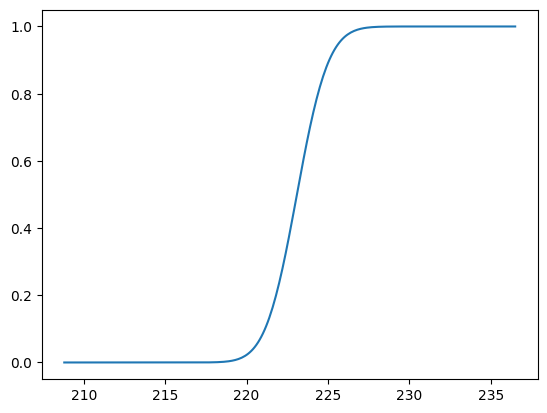

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(max_item[2].cdf_data.keys(), max_item[2].cdf_data.values())
plt.show()